### setting up

In [1]:
# Python Modules
import os
from sys import path as syspath
syspath.append("../")

from collections import OrderedDict
from collections.abc import Mapping
import pickle as pkl
from copy import deepcopy

# Data Modules
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from sklearn.linear_model import LinearRegression

# Util Modules
from util.model_functions import getBrickDict
from util.td_model import ThermodynamicModel
from util.data_functions import lett2idx
from util.other_datasets_porting import *

# Bio Modules
from Bio import SeqIO

# Plotting Modules
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
# Definitions
def showdf(a_):
    from IPython.display import display
    display(a_.applymap("{0:0.1f}".format))
    

In [3]:
shinedalgarno = "aggag"

In [11]:
data = pd.read_excel("../data/review_datasets/Data_for_Srdjan.xlsx", sheet_name=0)
data.columns = [c.lower() for c in data.columns]
data["promoter sequence"].apply(lambda xi: xi.find(shinedalgarno)).value_counts()

promoter sequence
-1    4351
Name: count, dtype: int64

{'within': array([0.24113055, 0.25934596, 0.25857065, 0.24095284]),
 'outside': array([0.29509327, 0.20487764, 0.2063366 , 0.29369249])}

{'within': array([0.24113055, 0.25934596, 0.25857065, 0.24095284]),
 'outside': array([0.29509327, 0.20487764, 0.2063366 , 0.29369249])}

{'within': array([0.24113055, 0.25934596, 0.25857065, 0.24095284]),
 'outside': array([0.29509327, 0.20487764, 0.2063366 , 0.29369249])}

{'within': array([0.24113055, 0.25934596, 0.25857065, 0.24095284]),
 'outside': array([0.29509327, 0.20487764, 0.2063366 , 0.29369249])}

So, no Shine-Delgarno anywhere.

In [12]:
data['promoter length'] = data["promoter sequence"].apply(len)
data["promoter length"].value_counts()

promoter length
78    4350
35       1
Name: count, dtype: int64

In [13]:
data.iloc[-1]

promoter id                                              J23100
promoter sequence           TTGACGGCTAGCTCAGTCCTAGGTACAGTGCTAGC
normalized-tx-rate-mean                                     1.0
normalized-tx-rate-stdev                                    0.0
promoter length                                              35
Name: 4350, dtype: object

promoter id                                              J23100
promoter sequence           TTGACGGCTAGCTCAGTCCTAGGTACAGTGCTAGC
normalized-tx-rate-mean                                     1.0
normalized-tx-rate-stdev                                    0.0
promoter length                                              35
Name: 4350, dtype: object

In [14]:
# the last entry is the sequence to which it was normalized and we exclude it 
normRow = data.iloc[-1].copy()

In [15]:
data = data.iloc[:-1]

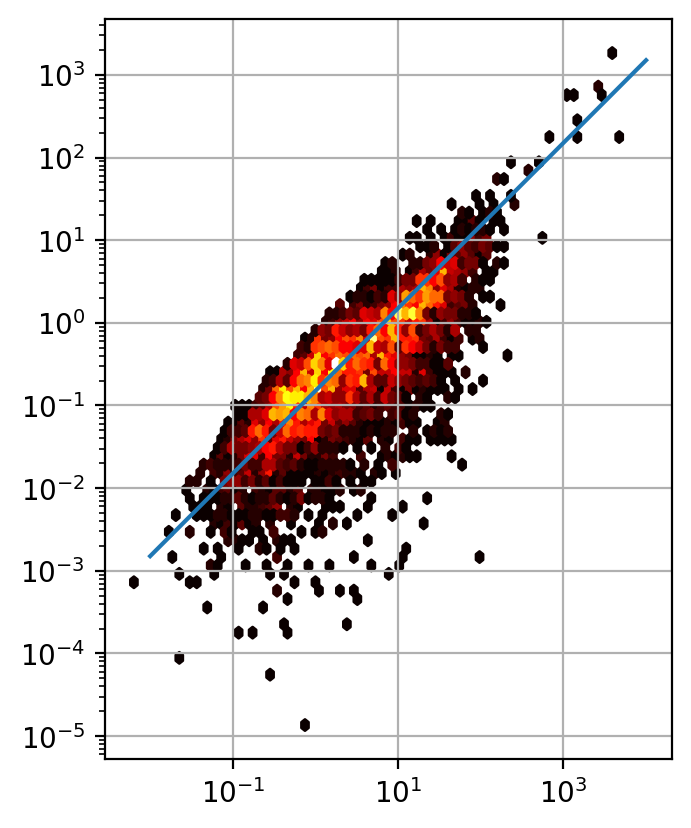

In [16]:
plt.hexbin(
    data['normalized-tx-rate-mean'].values,
    data['normalized-tx-rate-stdev'].values,
    cmap="hot",
    mincnt=1,
    xscale="log",
    yscale="log",
    gridsize=70
);
mr = np.geomspace(.01, 1e4)
k = (data['normalized-tx-rate-stdev']/data['normalized-tx-rate-mean']).mean()
plt.plot(mr, mr*k)
plt.gca().set_aspect("equal")
plt.grid()

In [17]:
data["loglum-mean"] = np.log10(data["normalized-tx-rate-mean"])

In [18]:
data["loglum-stdev"] = data["normalized-tx-rate-stdev"]/data["normalized-tx-rate-mean"]/np.log(10)

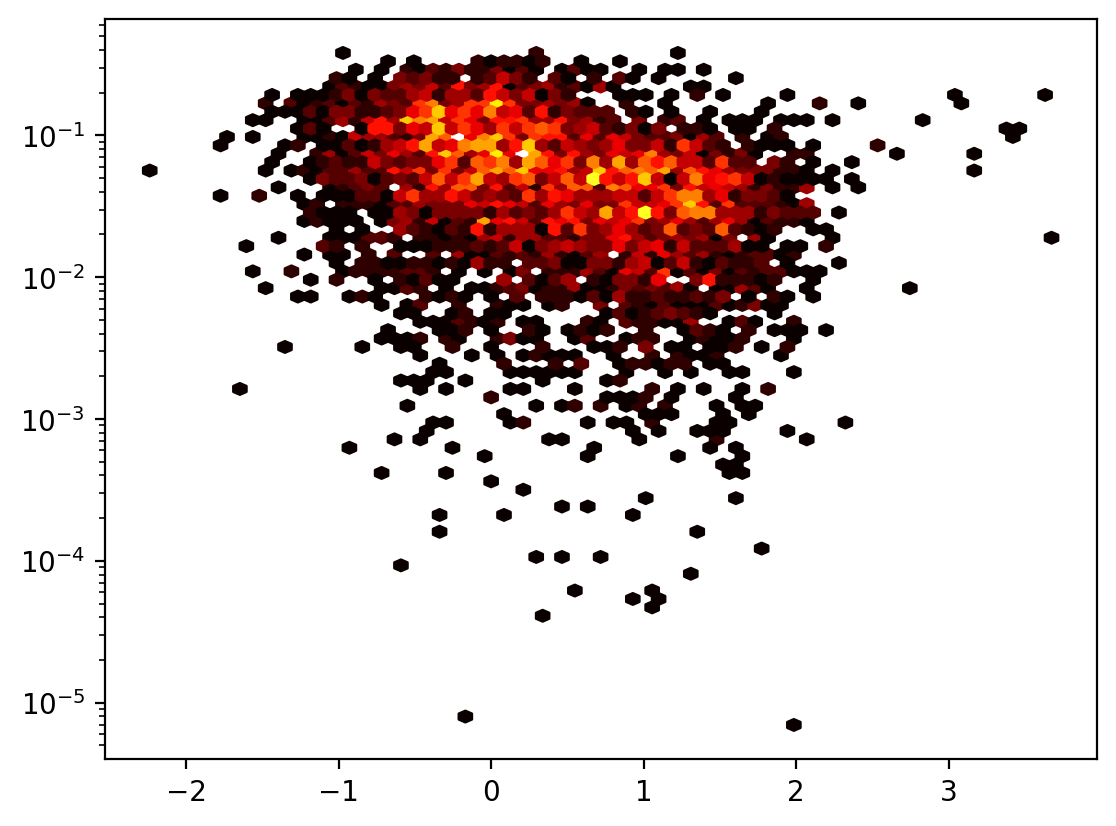

In [19]:
plt.hexbin(
    data['loglum-mean'].values,
    data['loglum-stdev'].values,
    cmap="hot",
    mincnt=1,
    yscale="log",
    gridsize=70
);
# mr = np.geomspace(.01, 1e4)
# k = (data['normalized-tx-rate-stdev']/data['normalized-tx-rate-mean']).mean()
# plt.plot(mr, mr*k)
# plt.gca().set_aspect("equal")
# plt.grid()

In [20]:
errs = data['loglum-stdev'].values

In [21]:
err_bound = np.percentile(errs,10)

In [22]:
lums = data['loglum-mean'].values

In [23]:
1-np.mean(errs**2)/lums.var()

0.9876207815429556

In [24]:
1-3000*np.mean(err_bound**2)/lums.var()

0.7051160743461077

In [25]:
np.mean(errs**2)/lums.var()

0.012379218457044386

(array([217., 195., 227., 170., 189., 160., 204., 177., 163., 141., 142.,
        129., 152., 128., 137., 125., 103.,  87.,  94.,  84.,  77.,  77.,
         61.,  55.,  65.,  53.,  52.,  49.,  50.,  35.,  35.,  31.,  42.,
         44.,  29.,  30.,  32.,  24.,  19.,  27.,  29.,  25.,  25.,  29.,
         17.,  22.,  19.,  10.,  15.,   9.,  21.,  14.,   9.,  13.,  11.,
         11.,   8.,  12.,   7.,  15.,   7.,   7.,   8.,   6.,   6.,   6.,
          1.,   7.,   9.,   2.,   6.,   2.,   3.,   1.,   6.,   9.,   4.,
          2.,   3.,   0.,   4.,   2.,   1.,   0.,   2.,   2.,   1.,   0.,
          2.,   1.,   3.,   0.,   1.,   1.,   0.,   2.,   0.,   0.,   0.,
          1.]),
 array([6.95960119e-06, 3.81798967e-03, 7.62901973e-03, 1.14400498e-02,
        1.52510799e-02, 1.90621099e-02, 2.28731400e-02, 2.66841701e-02,
        3.04952001e-02, 3.43062302e-02, 3.81172603e-02, 4.19282903e-02,
        4.57393204e-02, 4.95503505e-02, 5.33613805e-02, 5.71724106e-02,
        6.09834407e-02, 6.4794

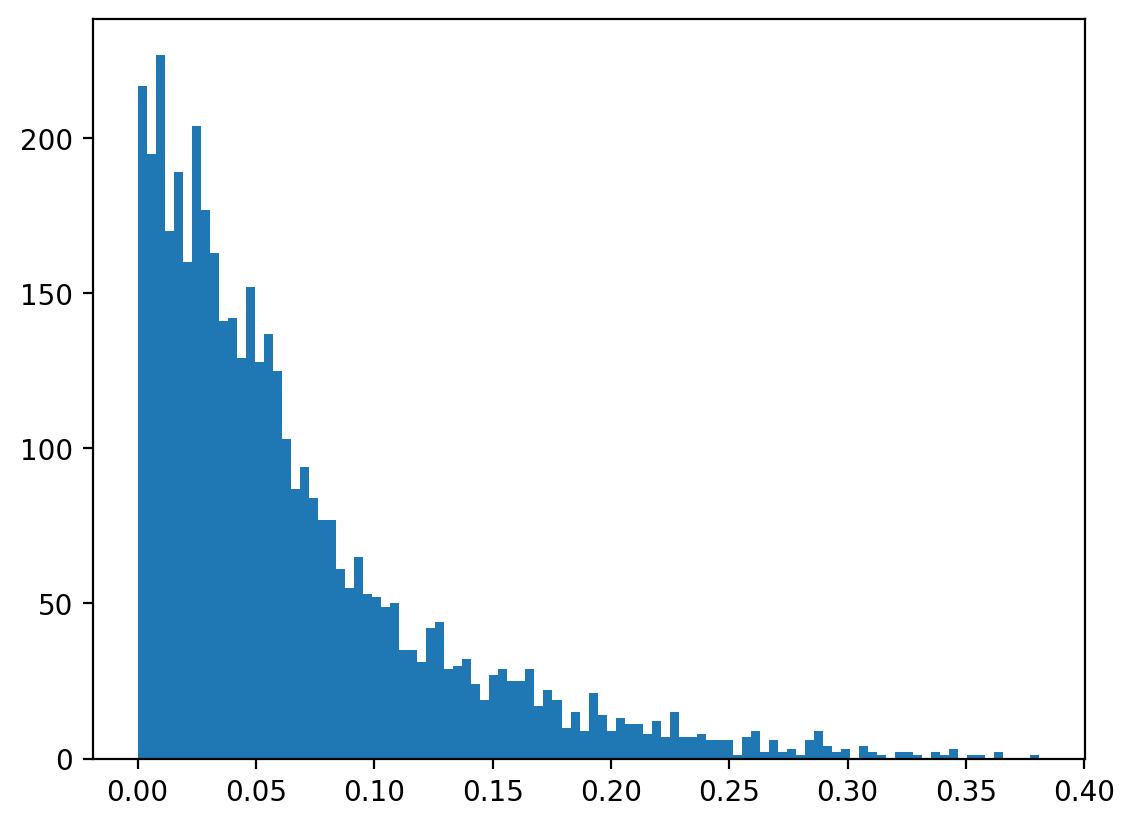

In [26]:
plt.hist(errs,100)

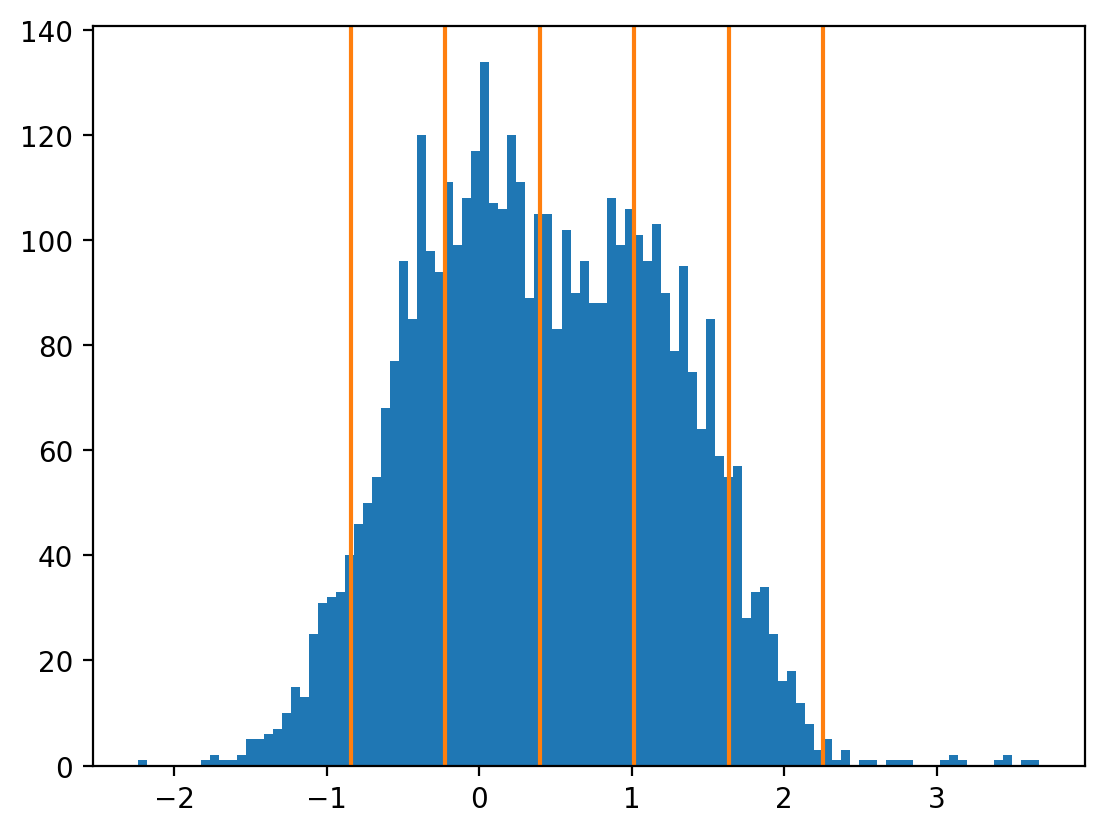

In [27]:
nbins = 7
plt.hist(lums,100)
boundaries = np.linspace(np.percentile(lums, 5), np.percentile(lums, 99.5), nbins-1)
for b in boundaries:
    plt.axvline(b,color="C1")
digilums = np.digitize(lums, boundaries)

In [28]:
w = np.ones(len(data))*np.nan

In [29]:
for i in range(nbins):
    w[digilums==i] = 1/(digilums==i).sum()

In [30]:
weights = {
    "equinumbered": w,
    "blind": 1/errs**2,
    "bounded": 1/(errs**2+err_bound**2),
    "no": np.ones(len(data))
}

Text(0.5, 0, 'log10 weights')

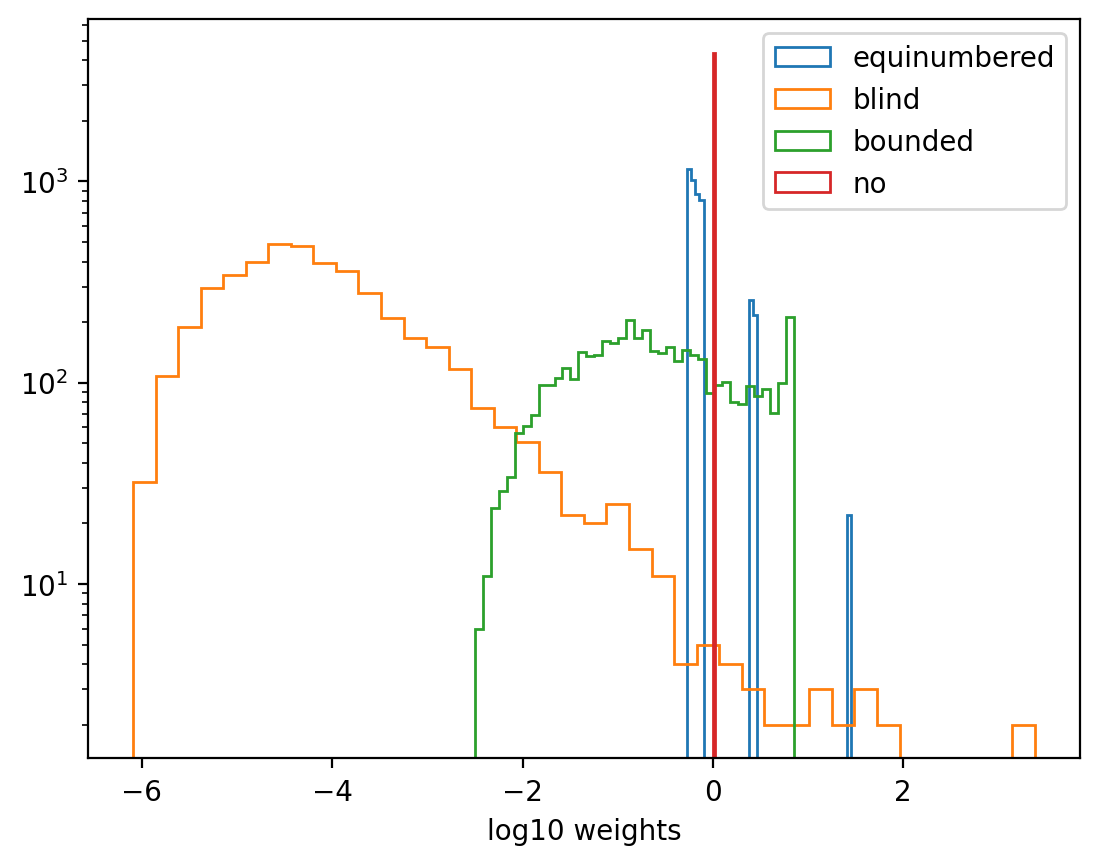

In [31]:
for k in weights:
    weights[k] = weights[k]/weights[k].sum()*len(data)
    plt.hist(np.log10(weights[k]),40, log=True, histtype="step", label=k)
plt.legend()
plt.xlabel("log10 weights")

In [32]:
lums = data['loglum-mean'].values

In [33]:
numseq = np.array([[lett2idx[l] for l in s.lower()] for s in data['promoter sequence']],dtype=np.int8)

In [34]:
numseq.shape

(4350, 78)

In [35]:
with open("../models/fitted_on_Pr.Pl.36N/model_[5]_extended", "rb") as f:
    full_model = pkl.load(f)

C:\Users\drago\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [36]:
with open("../models/fitted_on_Pr.Pl.36N/model_[0]_stm.dmp", "rb") as f:
    simple_model = pkl.load(f)

In [37]:
with open("../models/fitted_on_Pr/model_[4]_stm+flex+cumul+rbs+rc.dmp", "rb") as f:
    full_model_Pr = pkl.load(f)

In [38]:
with open("../models/fitted_on_Pr/model_[0]_stm.dmp", "rb") as f:
    simple_model_Pr = pkl.load(f)

In [39]:
tdmodels = {
    "standard": dict2tdm(simple_model),
    "extended": dict2tdm(full_model),
    "standard[Pr]": dict2tdm(simple_model_Pr),
    "extended[Pr]": dict2tdm(full_model_Pr),
}

In [40]:
bricks = {k:tdmodels[k].sequences2bricks(numseq) for k in tdmodels}

In [41]:
{kk: {k: bricks[kk][k].shape for k in bricks[kk]} for kk in bricks}

{'standard': {'frw': (4350, 47, 1)},
 'extended': {'frw': (4350, 47, 5), 'rc': (4350, 47, 5)},
 'standard[Pr]': {'frw': (4350, 47, 1)},
 'extended[Pr]': {'frw': (4350, 47, 5), 'rc': (4350, 47, 5)}}

0.002020078267967129

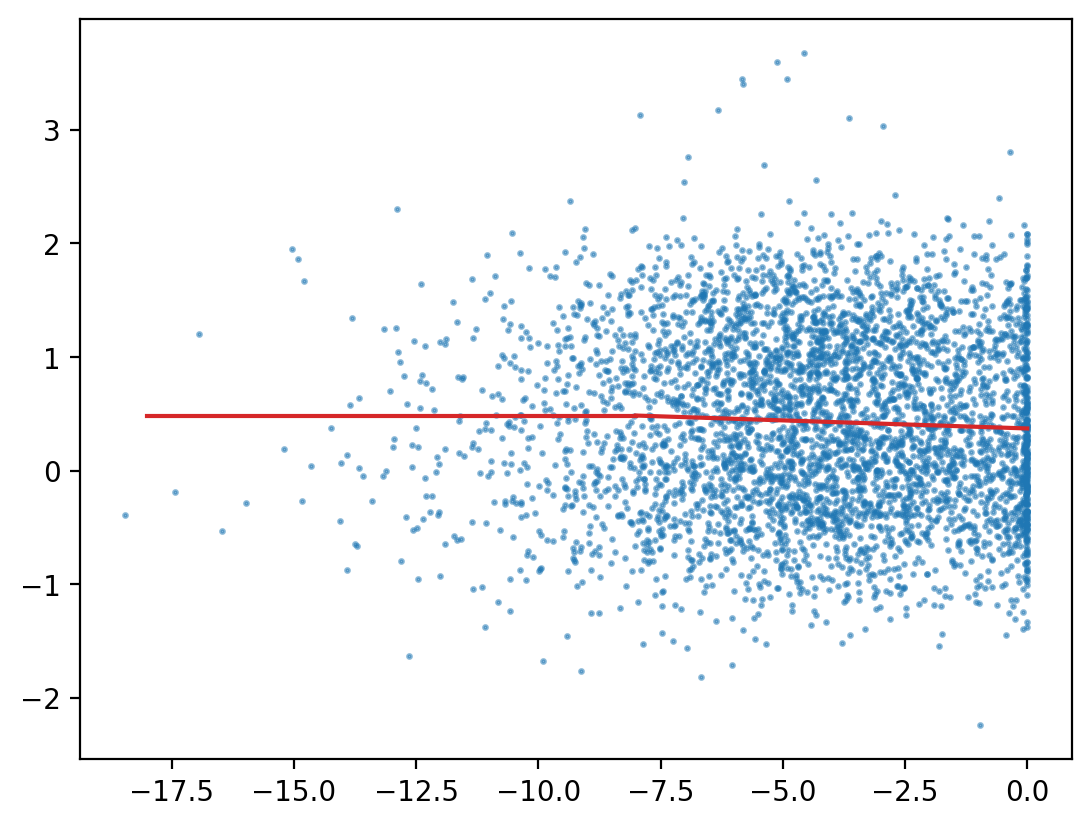

In [52]:
ax = plt.subplot(111)
evaluate_model(tdmodels["extended[Pr]"], bricks['extended[Pr]'], -10, -8, lums, ax=ax,)

# NEW GRAPH

In [43]:
%%timeit
evaluate_model(tdmodels["extended"], bricks['extended'], -10, -8, lums)

22.8 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
res = find_detection_threshold(tdmodels["extended"], bricks["extended"], -4, np.linspace(-6,-2), loglums=lums)

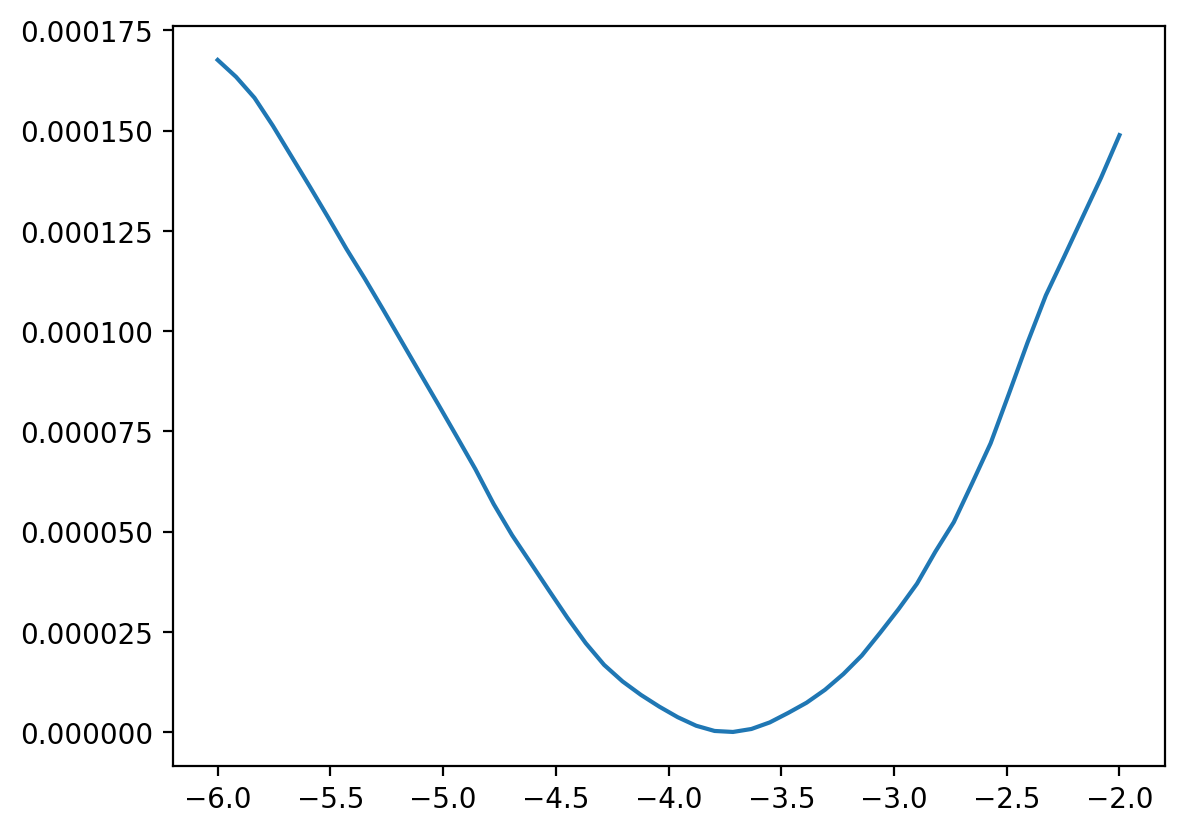

In [47]:
plt.plot(*res["all_res"])

CPU times: total: 8.97 s
Wall time: 17.1 s


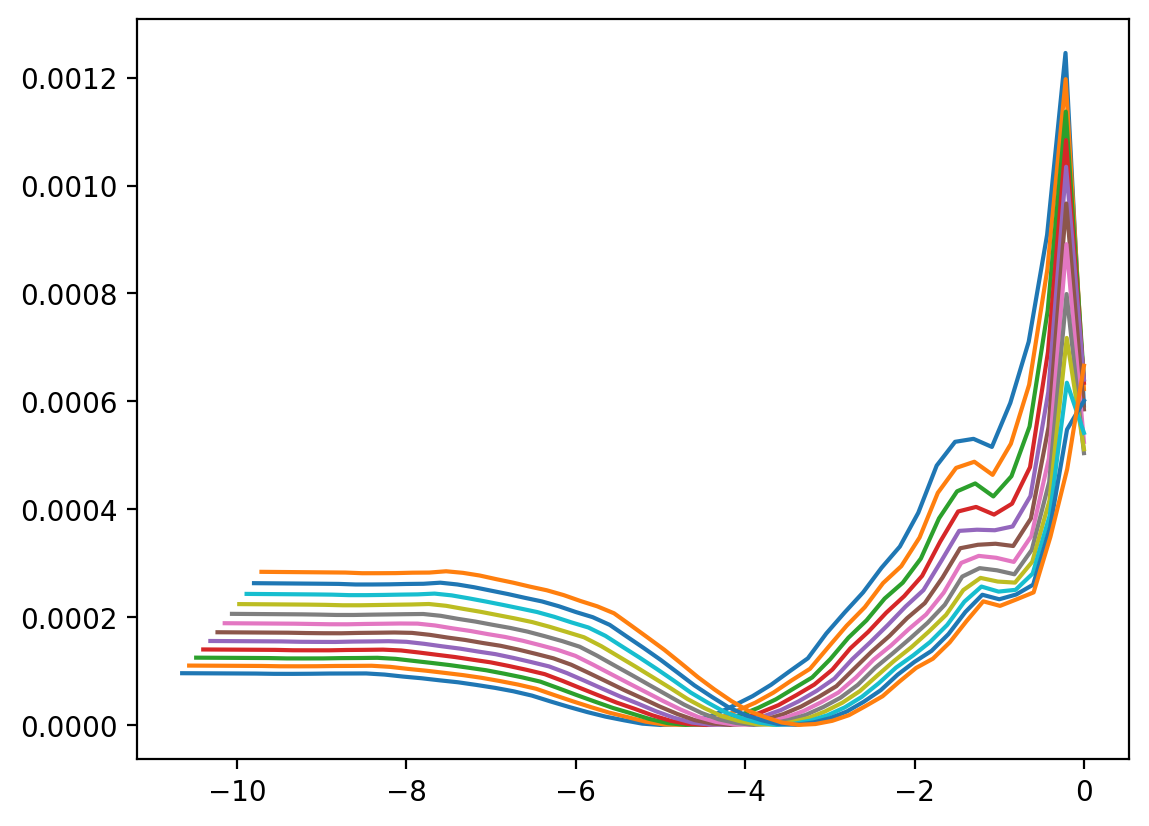

In [48]:
%%time
ax = plt.subplot(111)
opt_res = find_delta_mu(tdmodels["extended"], bricks["extended"], delta_mus=np.arange(-6,-3, .25), loglums=lums, ax=ax)

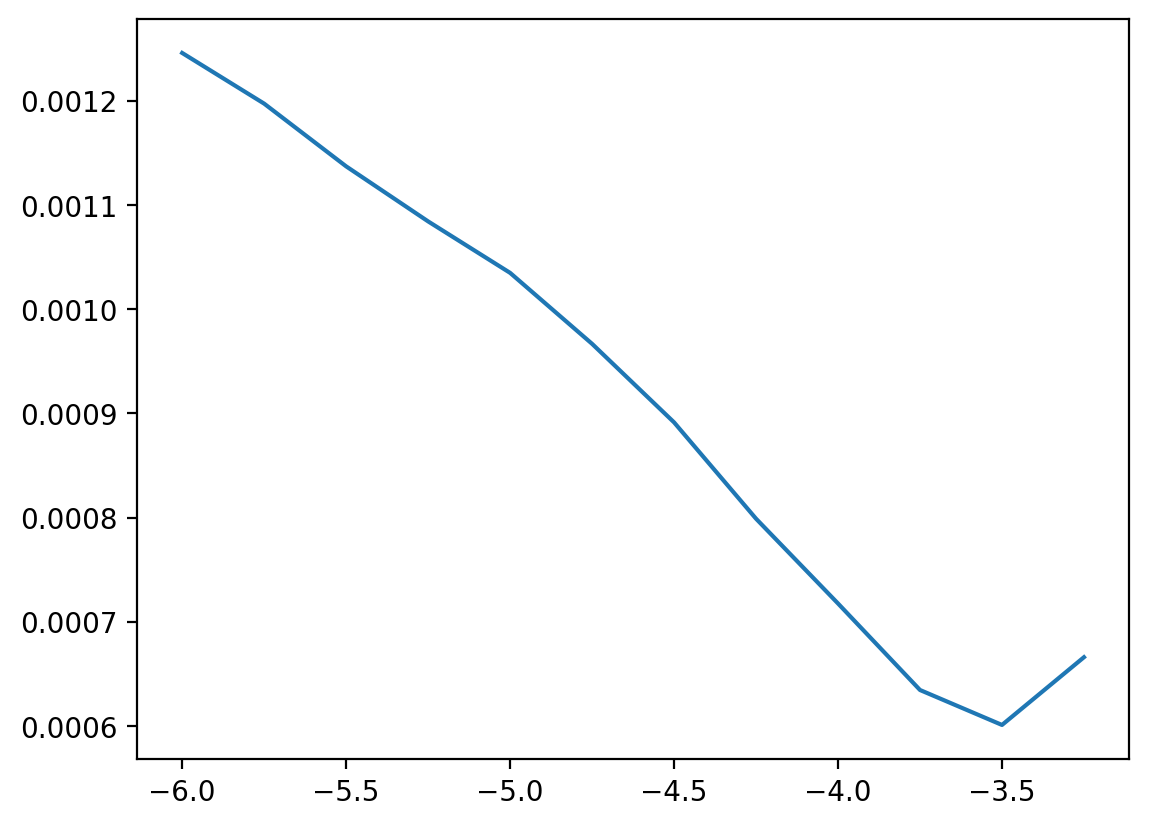

In [49]:
plt.plot(*opt_res["all_res"])

## no weights

CPU times: total: 30.2 s
Wall time: 53.4 s


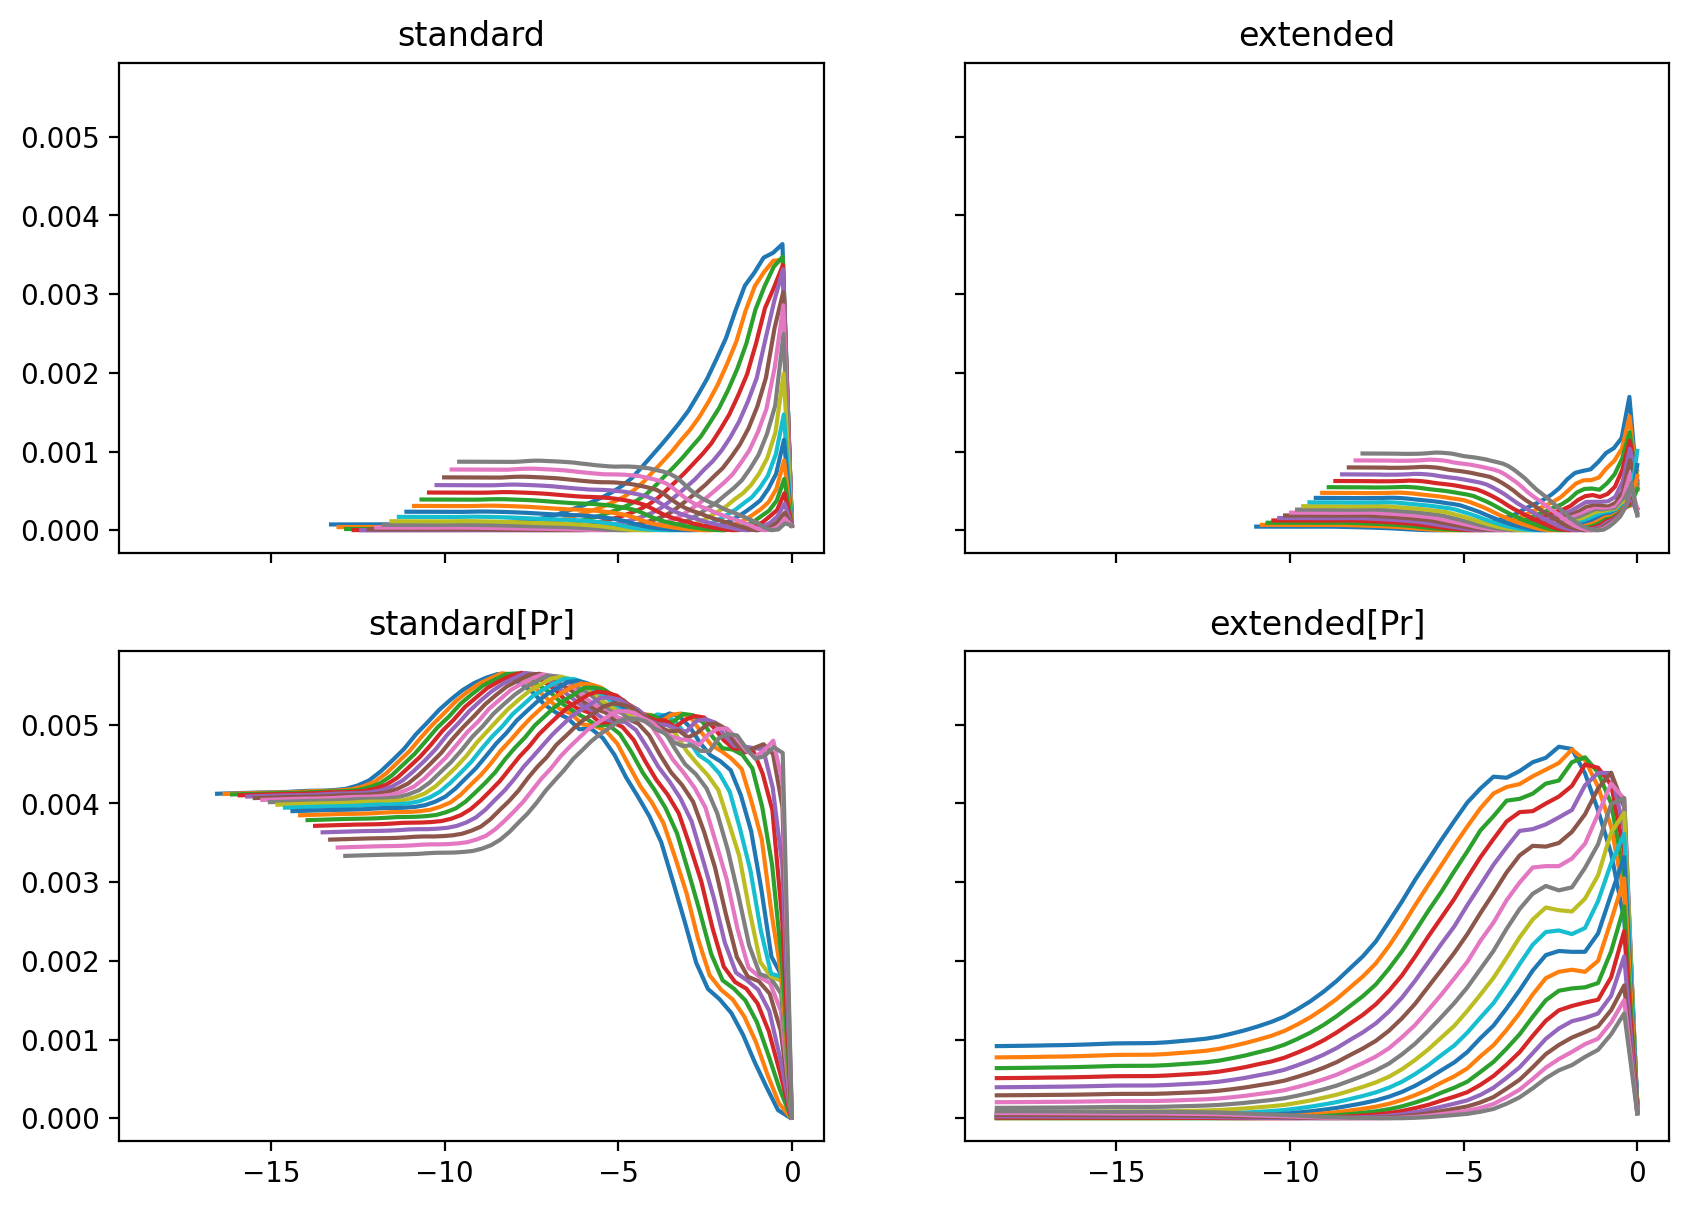

In [50]:
%%time
fig, axs = plt.subplots(2,2,figsize=(10,7), sharey=True, sharex=True)
opt_res = {}
for ax,k in zip(axs.flat, tdmodels):
    opt_res[k] = find_delta_mu(tdmodels[k], bricks[k], delta_mus=np.arange(-7,2,.5), loglums=lums, ax=ax)
    ax.set_title(k)

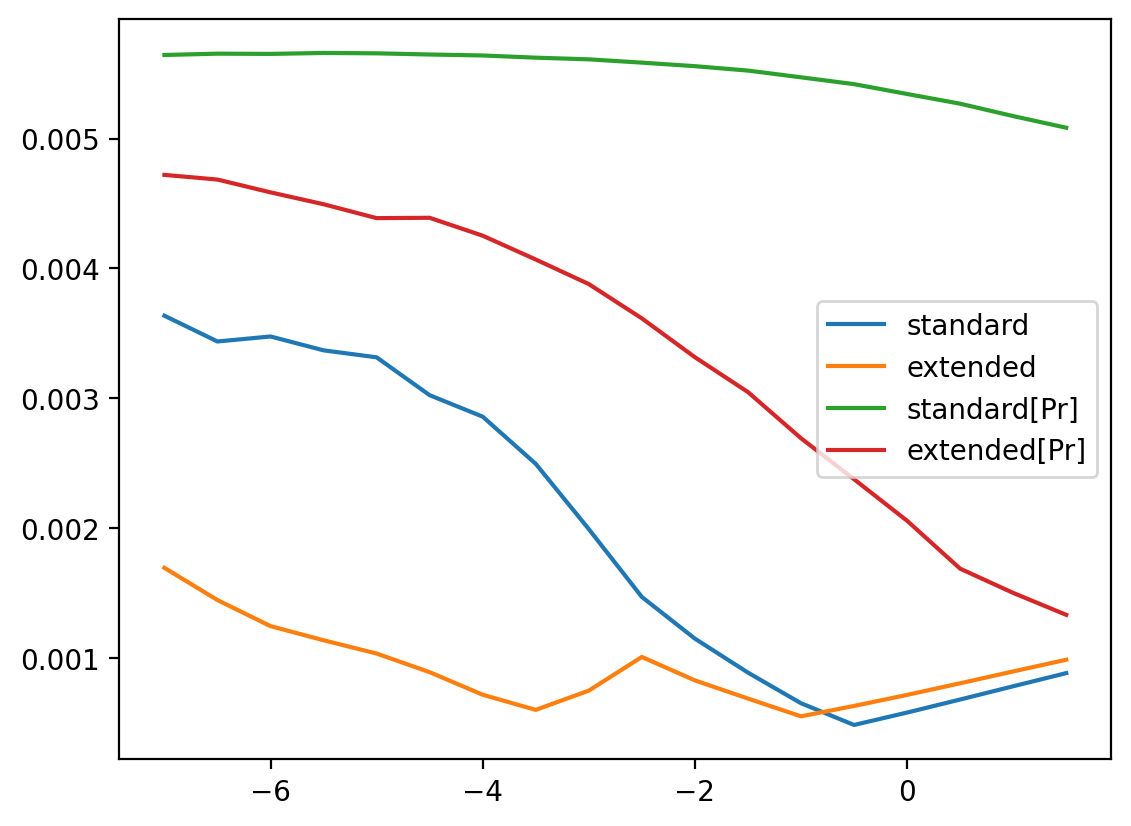

In [51]:
for k in opt_res:
    plt.plot(*opt_res[k]["all_res"], label=k)
plt.legend()

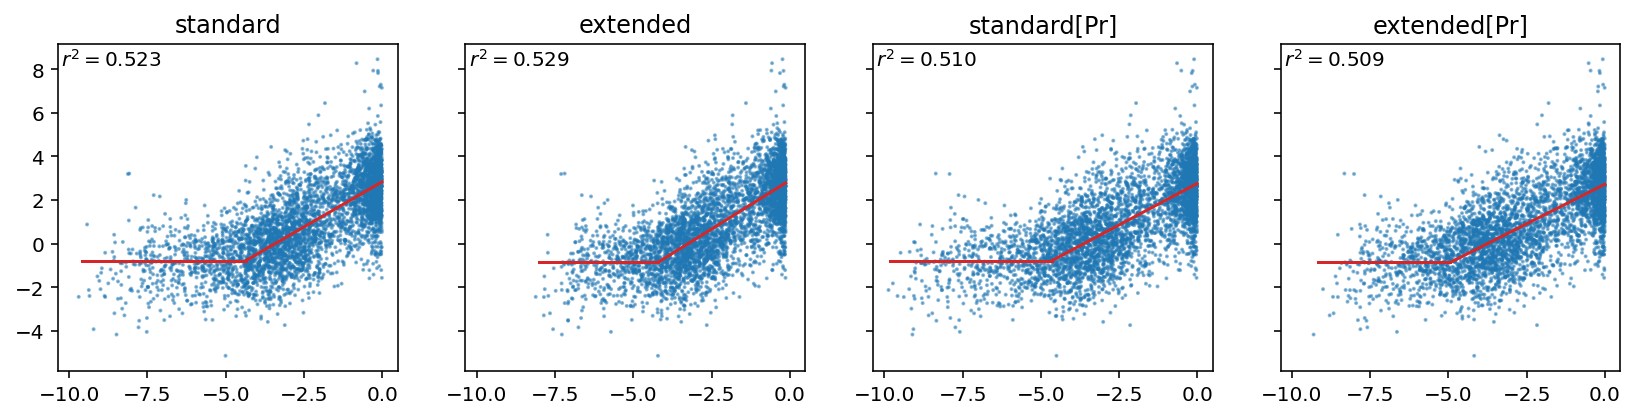

In [49]:
fig, axs = plt.subplots(1,4,figsize=(14,3), sharex=True, sharey=True)
for ax,k in zip(axs.flat, tdmodels):
    evaluate_model(
        tdmodels[k],
        bricks[k],
        delta_mu=opt_res[k]["delta_mu_opt"],
        detection_th=opt_res[k]["detection_th_opt"],
        loglums=lums,
        ax = ax

    )
    ax.set_title(k)
    ax.text(.01,.99,"$r^2=%.3f$"%(opt_res[k]["score_opt"]),va="top",transform=ax.transAxes)

## blind weigths

CPU times: user 36.8 s, sys: 18.8 s, total: 55.7 s
Wall time: 55.7 s


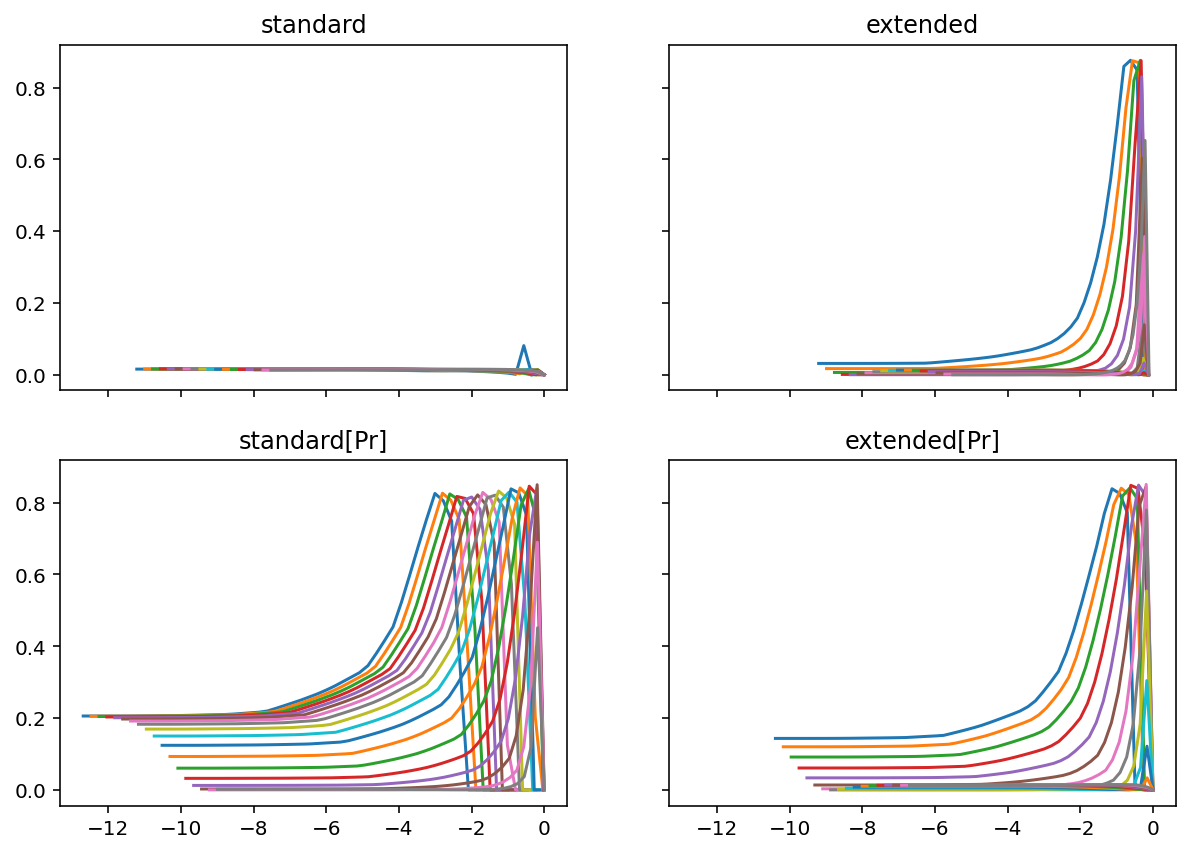

In [50]:
%%time
fig, axs = plt.subplots(2,2,figsize=(10,7), sharey=True, sharex=True)
opt_res = {}
for ax,k in zip(axs.flat, tdmodels):
    opt_res[k] = find_delta_mu(tdmodels[k], bricks[k], delta_mus=np.arange(-7,2,.5), loglums=lums, ax=ax, weights=weights["blind"])
    ax.set_title(k)

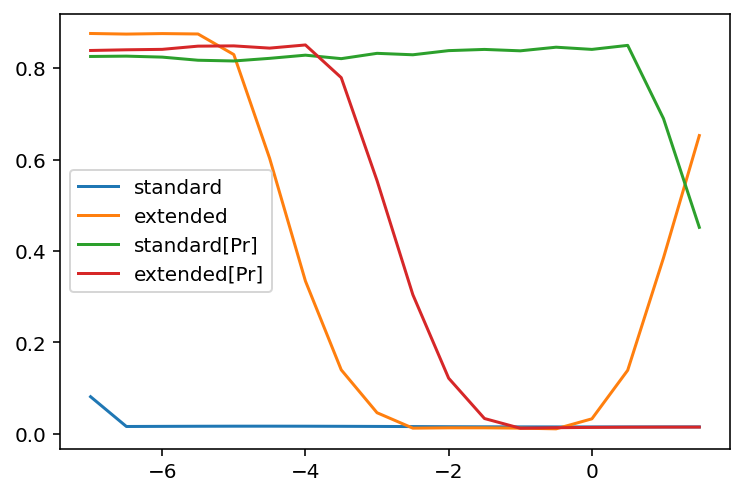

In [51]:
for k in opt_res:
    plt.plot(*opt_res[k]["all_res"], label=k)
plt.legend()

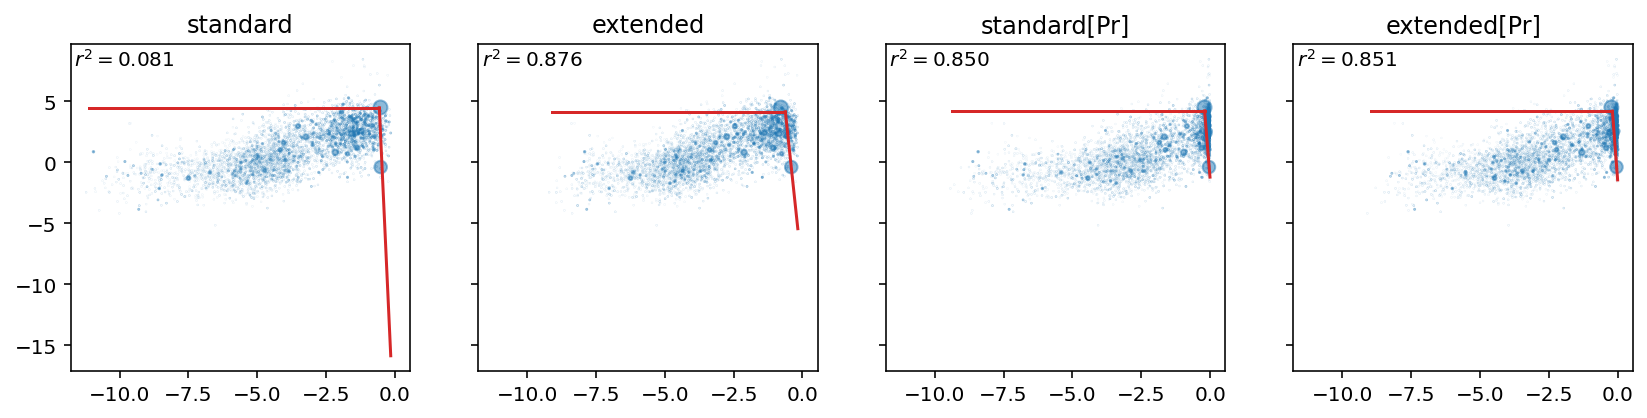

In [52]:
fig, axs = plt.subplots(1,4,figsize=(14,3), sharex=True, sharey=True)
for ax,k in zip(axs.flat, tdmodels):
    score = evaluate_model(
        tdmodels[k],
        bricks[k],
        delta_mu=opt_res[k]["delta_mu_opt"],
        detection_th=opt_res[k]["detection_th_opt"],
        loglums=lums,
        ax = ax,
        weights = weights["blind"]
    )
    assert score == opt_res[k]["score_opt"]
    ax.set_title(k)
    ax.text(.01,.99,"$r^2=%.3f$"%(opt_res[k]["score_opt"]),va="top",transform=ax.transAxes)

## bounded weights

CPU times: user 36.7 s, sys: 18.6 s, total: 55.3 s
Wall time: 55.3 s


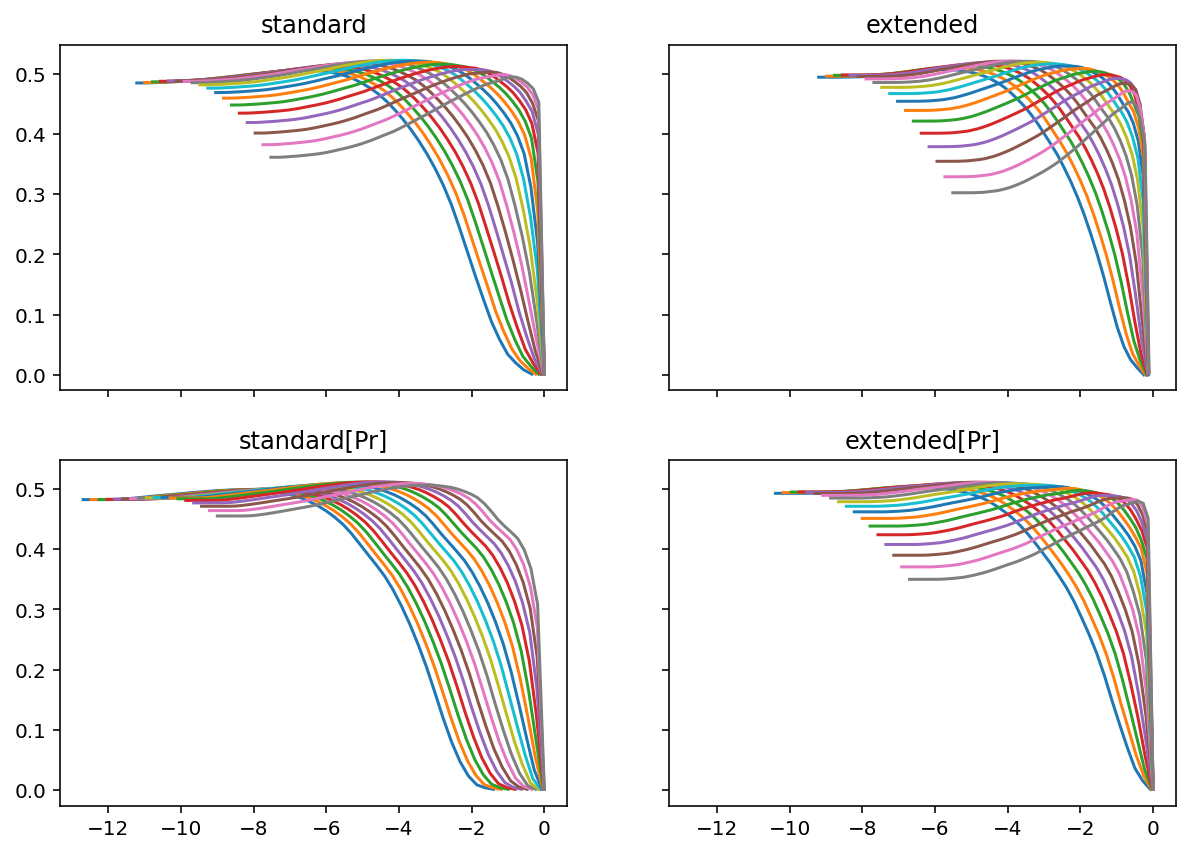

In [53]:
%%time
fig, axs = plt.subplots(2,2,figsize=(10,7), sharey=True, sharex=True)
opt_res = {}
for ax,k in zip(axs.flat, tdmodels):
    opt_res[k] = find_delta_mu(tdmodels[k], bricks[k], delta_mus=np.arange(-7,2,.5), loglums=lums, ax=ax, weights=weights["bounded"])
    ax.set_title(k)

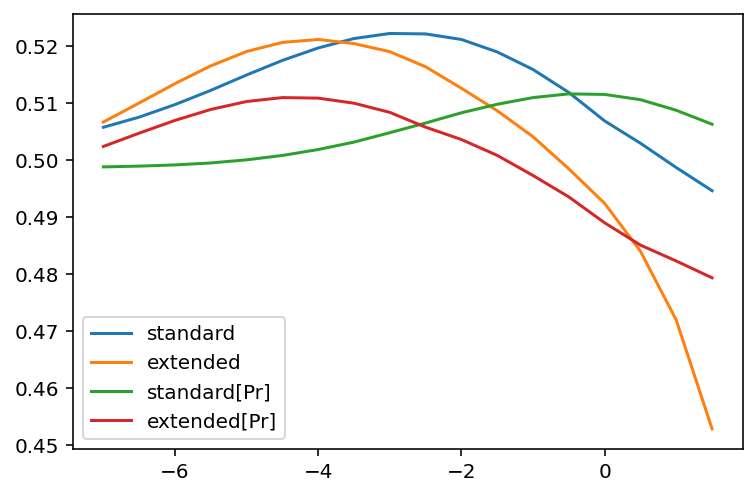

In [54]:
for k in opt_res:
    plt.plot(*opt_res[k]["all_res"], label=k)
plt.legend()

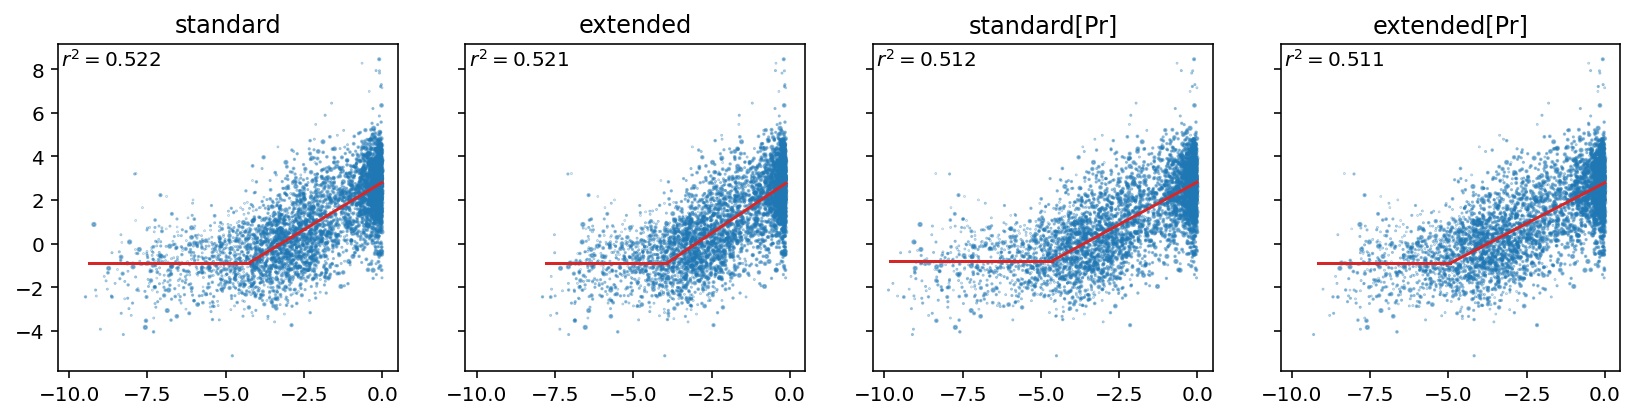

In [55]:
fig, axs = plt.subplots(1,4,figsize=(14,3), sharex=True, sharey=True)
for ax,k in zip(axs.flat, tdmodels):
    score = evaluate_model(
        tdmodels[k],
        bricks[k],
        delta_mu=opt_res[k]["delta_mu_opt"],
        detection_th=opt_res[k]["detection_th_opt"],
        loglums=lums,
        ax = ax,
        weights = weights["bounded"]
    )
    assert score == opt_res[k]["score_opt"]
    ax.set_title(k)
    ax.text(.01,.99,"$r^2=%.3f$"%(opt_res[k]["score_opt"]),va="top",transform=ax.transAxes)

## equiweighted

CPU times: user 36.3 s, sys: 19.4 s, total: 55.8 s
Wall time: 55.8 s


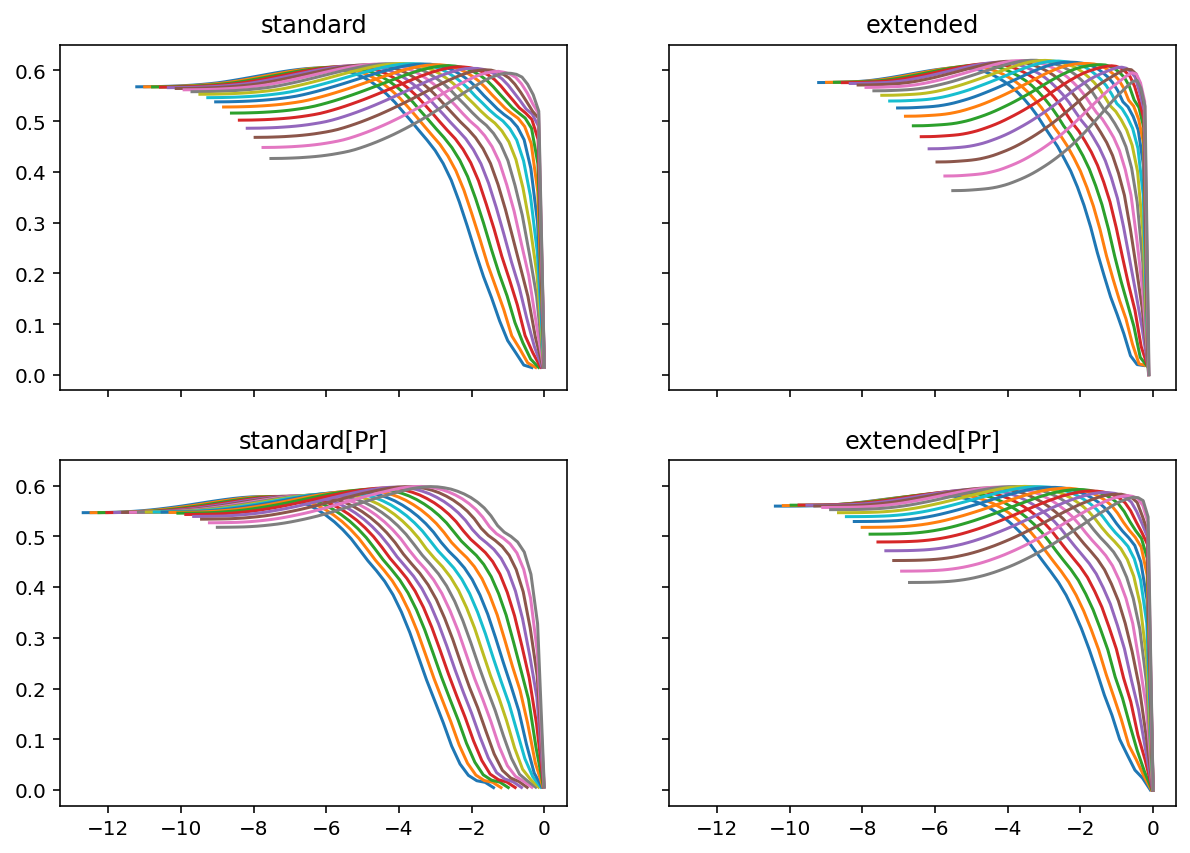

In [56]:
%%time
fig, axs = plt.subplots(2,2,figsize=(10,7), sharey=True, sharex=True)
opt_res = {}
for ax,k in zip(axs.flat, tdmodels):
    opt_res[k] = find_delta_mu(tdmodels[k], bricks[k], delta_mus=np.arange(-7,2,.5), loglums=lums, ax=ax, weights=weights["equinumbered"])
    ax.set_title(k)

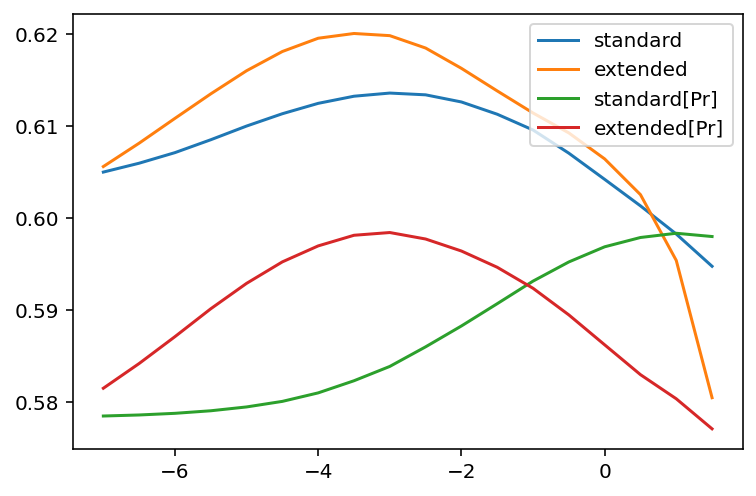

In [57]:
for k in opt_res:
    plt.plot(*opt_res[k]["all_res"], label=k)
plt.legend()

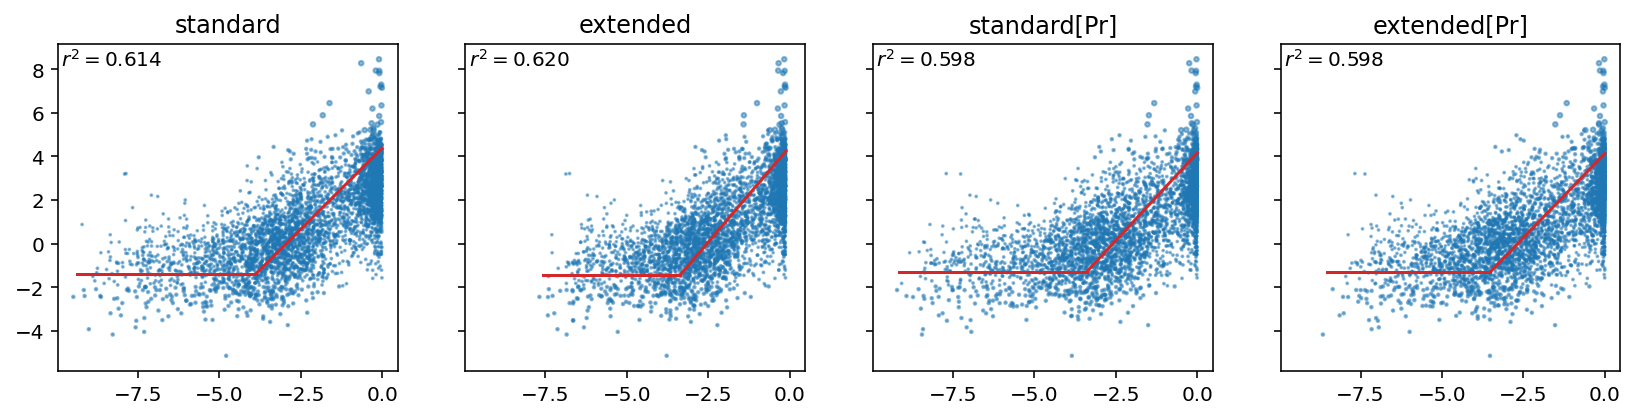

In [58]:
fig, axs = plt.subplots(1,4,figsize=(14,3), sharex=True, sharey=True)
for ax,k in zip(axs.flat, tdmodels):
    score = evaluate_model(
        tdmodels[k],
        bricks[k],
        delta_mu=opt_res[k]["delta_mu_opt"],
        detection_th=opt_res[k]["detection_th_opt"],
        loglums=lums,
        ax = ax,
        weights = weights["equinumbered"]
    )
    assert score == opt_res[k]["score_opt"]
    ax.set_title(k)
    ax.text(.01,.99,"$r^2=%.3f$"%(opt_res[k]["score_opt"]),va="top",transform=ax.transAxes)

In [32]:
# from scipy.stats import median_abs_deviation

In [33]:
# dmu = -10
# # detectionTh = .5+dmu
# pons_1 = tdsimple.bricks2pons({k:bricks[k]-dmu for k in bricks})
# # plt.hexbin(np.log10(pons_1), np.log10(lums), bins="log", mincnt=1)
# x = np.log10(pons_1)
# y = np.log10(lums)
# # plt.plot(x, y, ".", ms=2, alpha= .5)
# # w = np.ones(len(lums))
# w = weights**.1
# w = w/w.sum()*len(w)
# for i in range(1):
#     fig, axs = plt.subplots(1,2,figsize=(7,3))
#     linReg.fit(x.reshape(-1,1), y, sample_weight=w)
#     xr = np.linspace(np.percentile(x,1),x.max())
#     yp = linReg.predict(x.reshape(-1,1))
#     err = y-yp
#     axs[0].scatter(x, y, s=w**.5, alpha= .5)
#     axs[0].plot(xr, linReg.predict(xr.reshape(-1,1)))
#     axs[0].set_ylabel("log10 luminosity")
#     axs[0].set_xlabel("log10 Pon")
#     axs[1].hist(err, 100, histtype="step", weights=w);
#     err_std = median_abs_deviation(err, scale="normal")
#     xc = (np.percentile(x,1)+np.percentile(x,90))/2
#     ff = (err>2.5*err_std) & (x<xc)
#     axs[0].plot(x[ff],y[ff],"C1x")
#     x = x[~ff]
#     y = y[~ff]
#     w = w[~ff]
# xx = np.exp(xr)
# axs[0].plot(xr,xx/(1+(xx/np.exp(-100))*3))

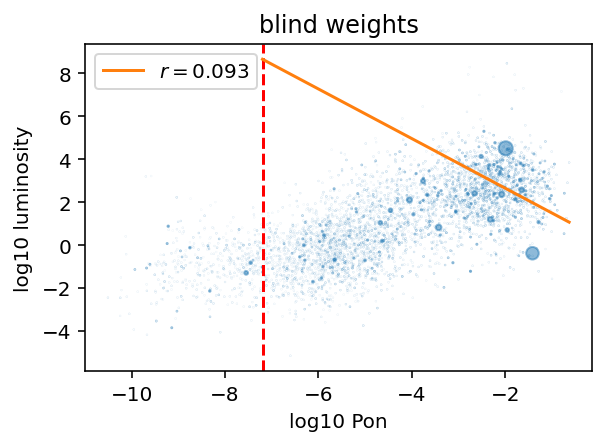

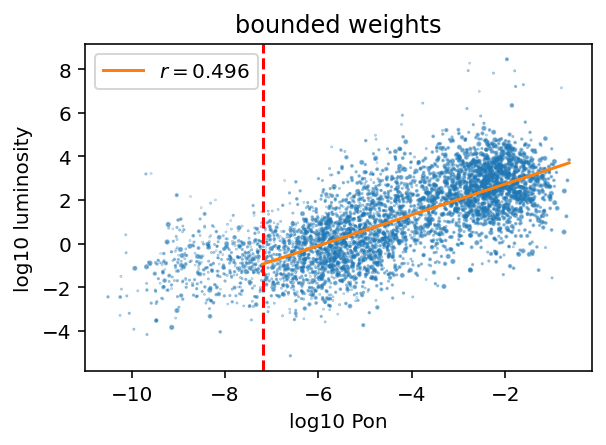

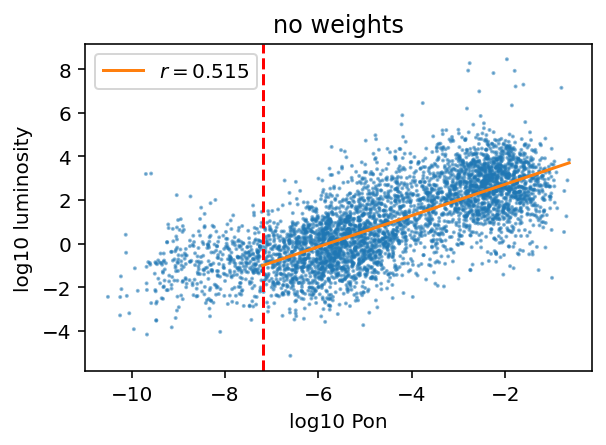

In [64]:
dmu = -10
# detectionTh = .5+dmu
pons_1 = tdmodel.bricks2pons({k:bricks[k]-dmu for k in bricks})
for k in weights:
    w = weights[k]
    w = w/w.sum()*len(w)
    x = np.log10(pons_1)
    xTh = np.percentile(x,10)
    y = lums.copy()
    fig, axs = plt.subplots(1,2,figsize=(10,3))
    axs[0].set_title(k+" weights")
    axs[0].scatter(x, y, s=w**.5, alpha= .5)
    axs[0].axvline(xTh, color="r", ls="--")
    x = np.maximum(x,xTh)
    linReg.fit(x.reshape(-1,1), y, sample_weight=w)
    xr = np.linspace(xTh,x.max())
    yp = linReg.predict(x.reshape(-1,1))
    err = y-yp
    score = linReg.score(x.reshape(-1,1), y, sample_weight=w)
    axs[0].plot(xr, linReg.predict(xr.reshape(-1,1)), "C1", label=r"$r=%.3f$"%score)
    axs[0].set_ylabel("log10 luminosity")
    axs[0].set_xlabel("log10 Pon")
    axs[1].hist(err, 100, histtype="step", weights=w);
    axs[0].legend()
    axs[1].remove()

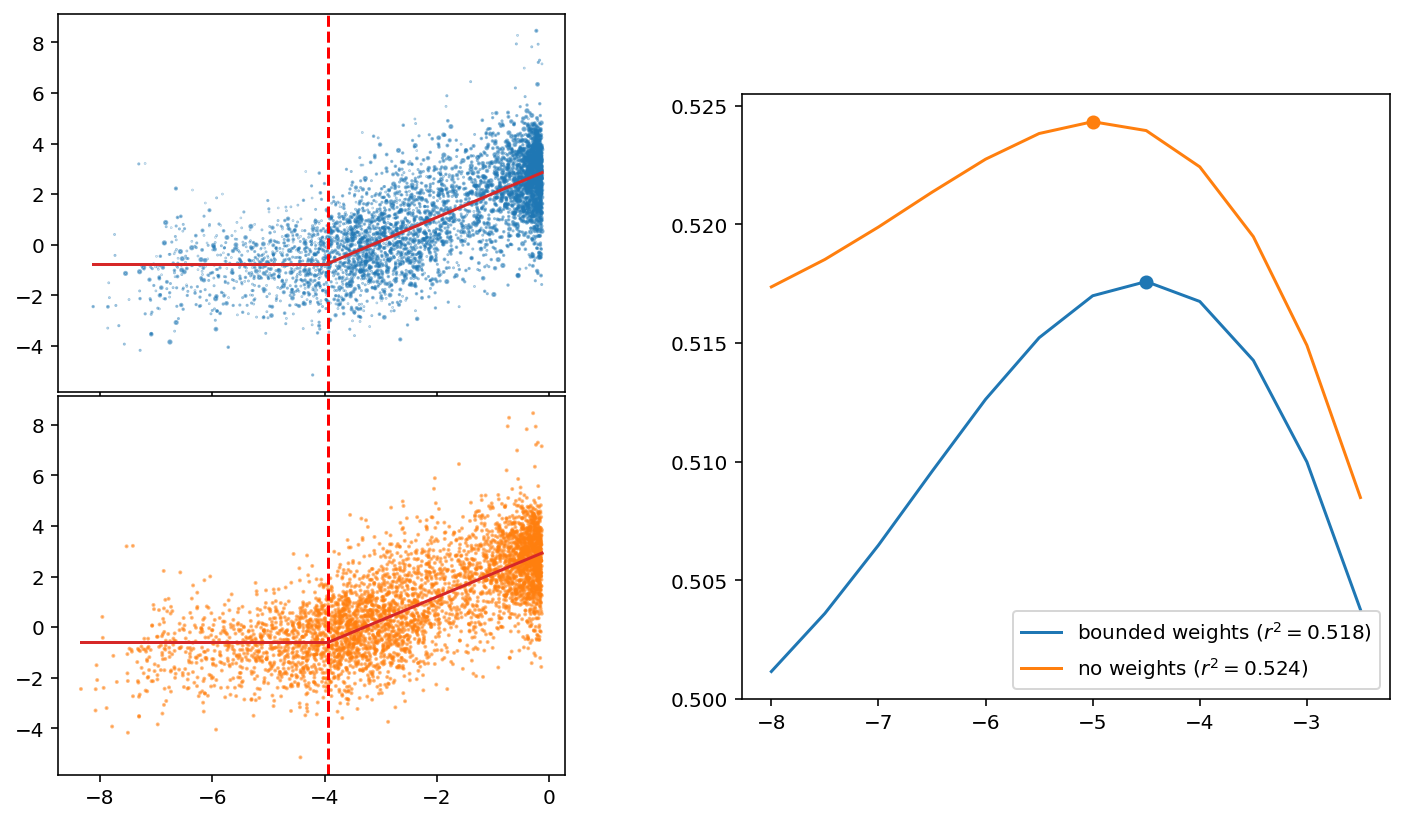

In [86]:
fig, axs = plt.subplots(2,2,figsize=(10,7), sharex=True, sharey=True)
axs[0,1].remove()
axs[1,1].remove()
axx = fig.add_axes([.6,.2,.45,.6])
for ax,k in zip(axs[:,0],["bounded","no"]):
    w = weights[k]
    dmus = np.arange(-8,-2,.5)
    rs = []
    for dmu in dmus:
        pons_1 = tdmodel.bricks2pons({k:bricks[k]-dmu for k in bricks})
        x = np.log10(pons_1)
        xTh = np.percentile(x,10)
        x = np.maximum(x,xTh)
        linReg.fit(x.reshape(-1,1), y, sample_weight=w)
        rs += [linReg.score(x.reshape(-1,1), y, sample_weight=w)]
    c = axx.plot(dmus, rs, label=r"%s weights ($r^2=%.3f$)"%(k, np.max(rs)))[0].get_color()
    dmu = dmus[np.argmax(rs)]
    axx.plot(dmu, np.max(rs),"o", c=c)
    pons_1 = tdmodel.bricks2pons({k:bricks[k]-dmu for k in bricks})
    x = np.log10(pons_1)
    ax.scatter(x, y, s=w**.5, alpha= .5, c=c)
    ax.axvline(xTh, color="r", ls="--")
    xmin = x.min()
    x = np.maximum(x,xTh)
    linReg.fit(x.reshape(-1,1), y, sample_weight=w)
    xr = np.linspace(xTh,x.max())
    yp = linReg.predict(x.reshape(-1,1))
    err = y-yp
    score = linReg.score(x.reshape(-1,1), y, sample_weight=w)
    yp = linReg.predict(xr.reshape(-1,1))
    ax.plot(xr, yp, "C3", label=r"$r=%.3f$"%score)
    ax.plot([xmin, xTh],[yp[0]]*2,"C3-")
axx.legend()
plt.subplots_adjust(hspace=.01)